In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
df = pd.read_csv('Flight_delay.csv')

In [ ]:
df.head()

In [ ]:
df = df[['DayOfWeek','Date','DepTime','Airline','Origin','Dest','CarrierDelay']]
df

In [ ]:
df.isnull().sum()

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

In [ ]:
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

In [ ]:
df = df.drop(columns=['Date'])

In [ ]:
categories = df.select_dtypes(include=['object']).columns
categories

In [ ]:
df_encoded = pd.get_dummies(df, drop_first=True)

In [ ]:
df_encoded['is_delayed_60+'] = np.where(df_encoded['CarrierDelay'] > 60, 1, 0)
# df_encoded['is_delayed_15+'] = np.where(df_encoded['CarrierDelay'] > 30, 1, 0)

In [ ]:
X = df_encoded.drop(columns=['is_delayed_60+', 'CarrierDelay'])
y = df_encoded['is_delayed_60+']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
train_set = pd.concat([X_train, y_train], axis= 1)

In [ ]:
categories

In [ ]:
# Reversing one-hot encoding for multiple sets of categorical variables
for category in categories:
    one_hot_columns = [col for col in train_set.columns if col.startswith(f'{category}_')]
    train_set[category] = train_set[one_hot_columns].idxmax(axis=1)
    train_set = train_set.drop(columns=one_hot_columns)
    train_set[category] = train_set[category].str.replace(f'{category}_', '')

In [ ]:
train_set

In [ ]:
train_set['is_delayed_60+'].value_counts()

In [ ]:
train_set['is_delayed_60+'].mean()

In [ ]:
train_set.groupby('Airline')['is_delayed_60+'].mean().sort_values(ascending=False).round(3)*100

In [ ]:
DayOfWeek_pct_delayed = train_set.groupby('DayOfWeek')['is_delayed_60+'].mean().round(3)*100
DayOfWeek_pct_delayed

In [ ]:
pct_delay_by_origin = train_set.groupby('Origin')['is_delayed_60+'].mean().sort_values(ascending=False).round(3)*100
pct_delay_by_origin.head(20)

In [ ]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(pct_delay_by_origin.values, bins=25, color='blue', edgecolor='black')

# Add labels and title
plt.title("Distribution of 60+ Minute Delays By Origins", fontsize=14)
plt.xlabel("Percentage of 60+ Minute Delays (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Show the plot
plt.show()

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=0, 
                              eval_metric='logloss')

In [ ]:
xgb_model

In [ ]:
# Train the model
xgb_model.fit(X_train, y_train)

In [ ]:
y_pred = xgb_model.predict(X_test)

In [ ]:
print("XGBoost Classifier (Baseline):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
# Predict probabilities for the test set (to calculate AUC)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # We need probabilities for the positive class

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

In [ ]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 250],
    'subsample': [0.6,  1.0]
}

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=0,
                              eval_metric='logloss')

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           cv=3, 
                           scoring='roc_auc', 
                           verbose=1, 
                           n_jobs=-1)

# Fit the grid search model
grid_search.fit(X_train, y_train)

In [ ]:
# Best parameters from GridSearch
print("Best parameters found: ", grid_search.best_params_)

# Predict with the best model
y_pred_best = grid_search.best_estimator_.predict(X_test)

# Evaluate the tuned XGBoost model
print("XGBoost Classifier (Tuned):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
cm

In [ ]:
# Predict probabilities for the test set (to calculate AUC)
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # We need probabilities for the positive class

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

In [ ]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Taşıyıcı dağılımı:
 UniqueCarrier
WN    119048
AA     73053
DL     30220
Name: count, dtype: int64
DropNA: 222321->222321
X shape: (222321, 248)  y shape: (222321,)
Train: (155624, 248) Test: (66697, 248)
MAE:  21.40 dk
RMSE: 32.98 dk
R²:   0.623


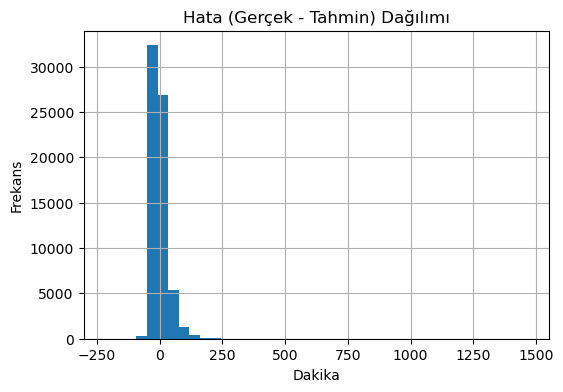

{'tahmini_varis_gecikmesi_dk': 57.90327072143555, 'tahmini_varis_saati_hhmm': '2023'}


C:\Users\harnk\AppData\Local\Temp\ipykernel_29844\4216103521.py:145: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  row[c] = 0
C:\Users\harnk\AppData\Local\Temp\ipykernel_29844\4216103521.py:145: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  row[c] = 0
C:\Users\harnk\AppData\Local\Temp\ipykernel_29844\4216103521.py:145: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inste

,DayOfWeek,Date,DepTime,ArrTime,CRSArrTime,UniqueCarrier,Airline,Origin,Dest,ArrDelay,DepHour,DepMinute,ArrPlannedHour,ArrPlannedMinute,Month,Day
0,4,2019-01-03,1829,1959,1925,WN,Southwest Airlines Co.,IND,BWI,34,18,29,19,25,1,3
1,4,2019-01-03,1937,2037,1940,WN,Southwest Airlines Co.,IND,LAS,57,19,37,19,40,1,3
2,4,2019-01-03,1644,1845,1725,WN,Southwest Airlines Co.,IND,MCO,80,16,44,17,25,1,3
3,4,2019-01-03,1452,1640,1625,WN,Southwest Airlines Co.,IND,PHX,15,14,52,16,25,1,3
4,4,2019-01-03,1323,1526,1510,WN,Southwest Airlines Co.,IND,TPA,16,13,23,15,10,1,3


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === 1) VERİYİ GÜVENLİ OKU ===
# - engine='python' + quotechar='"' + escapechar='\\' virgüllü alanları doğru parse eder
CSV_PATH = r"C:\Users\harnk\OneDrive\Masaüstü\flight_delay.csv"
df = pd.read_csv(
    CSV_PATH,
    engine="python",
    quotechar='"',
    escapechar='\\',
    encoding="utf-8"
)

# Sadece lazım olan kolonlar
need_cols = [
    'DayOfWeek','Date','DepTime','ArrTime','CRSArrTime',
    'UniqueCarrier','Airline','Origin','Dest',
    # hedef olarak ArrDelay'ı alacağız
    'ArrDelay'
]
missing = [c for c in need_cols if c not in df.columns]
if missing:
    raise ValueError(f"Dosyada beklenen kolonlar yok: {missing}")

df = df[need_cols].copy()

# === 2) SADECE AA / DL / WN ===
df = df[df['UniqueCarrier'].isin(['AA','DL','WN'])].copy()
print("Taşıyıcı dağılımı:\n", df['UniqueCarrier'].value_counts())

# === 3) TARİH/SAYISAL DÜZELTMELER ===
# Tarihi parse et (dosyada 03-01-2019 gibi görünüyor -> dayfirst=True)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

# Saat kolonlarını HHMM -> dakika/saat ayır
def hhmm_to_int(x):
    try:
        x = int(x)
        hh, mm = divmod(x, 100)
        if not (0 <= hh <= 24 and 0 <= mm <= 59):
            return np.nan, np.nan
        return hh, mm
    except Exception:
        return np.nan, np.nan

df[['DepHour','DepMinute']]   = df['DepTime'].apply(lambda z: pd.Series(hhmm_to_int(z)))
df[['ArrPlannedHour','ArrPlannedMinute']] = df['CRSArrTime'].apply(lambda z: pd.Series(hhmm_to_int(z)))

# Ay-gün çıkar
df['Month'] = df['Date'].dt.month
df['Day']   = df['Date'].dt.day

# Hedef: kaç dk geç gitti? ArrDelay (negatifler erken iniş)
# Eğitimde NaN içeren satırları at
before = len(df)
df = df.dropna(subset=['ArrDelay','DepHour','DepMinute','ArrPlannedHour','ArrPlannedMinute','Month','Day','DayOfWeek','Origin','Dest','UniqueCarrier'])
after = len(df)
print(f"DropNA: {before}->{after}")

# === 4) ONE-HOT ve ÖZELLİK MATRİSİ ===
# Kullanıcıdan alınabilecek/çıkarılabilecek girdiler:
# DayOfWeek, Month, Day, DepTime türevleri (DepHour/DepMinute), CRSArrTime türevleri,
# Origin, Dest, UniqueCarrier
feature_cols = [
    'DayOfWeek','Month','Day',
    'DepHour','DepMinute',
    'ArrPlannedHour','ArrPlannedMinute',
    'Origin','Dest','UniqueCarrier'
]
X_num = df[['DayOfWeek','Month','Day','DepHour','DepMinute','ArrPlannedHour','ArrPlannedMinute']].astype(float)
X_cat = pd.get_dummies(df[['Origin','Dest','UniqueCarrier']], drop_first=True)
X = pd.concat([X_num, X_cat], axis=1)

y = df['ArrDelay'].astype(float)

print("X shape:", X.shape, " y shape:", y.shape)
if len(X) == 0:
    raise ValueError("Filtreler sonrası satır kalmadı. CSV parse veya filtre koşullarını kontrol et.")

# === 5) TRAIN/TEST ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)
print("Train:", X_train.shape, "Test:", X_test.shape)

# === 6) MODEL: XGBRegressor (kaç dk gecikme) ===
xgb_reg = xgb.XGBRegressor(
    random_state=0,
    tree_method='hist',   # CPU için hızlı
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1
)
xgb_reg.fit(X_train, y_train)

# === 7) DEĞERLENDİRME ===
y_pred = xgb_reg.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2   = r2_score(y_test, y_pred)
print(f"MAE:  {mae:.2f} dk")
print(f"RMSE: {rmse:.2f} dk")
print(f"R²:   {r2:.3f}")

# (isteğe bağlı) hataların dağılımı
plt.figure(figsize=(6,4))
plt.hist(y_test - y_pred, bins=40)
plt.title("Hata (Gerçek - Tahmin) Dağılımı")
plt.xlabel("Dakika"); plt.ylabel("Frekans")
plt.grid(True); plt.show()

# === 8) KULLANICI GİRDİSİ İLE TEK SATIR TAHMİN ===
def predict_minutes_late(date_str, dep_hhmm, crs_arr_hhmm, origin, dest, carrier):
    # date_str: 'YYYY-MM-DD'
    dt = pd.to_datetime(date_str)
    m, d, dow = dt.month, dt.day, (dt.weekday()+1)  # 1=Mon..7=Sun

    dh, dm = hhmm_to_int(dep_hhmm)
    ah, am = hhmm_to_int(crs_arr_hhmm)

    row_num = pd.DataFrame([{
        'DayOfWeek': dow, 'Month': m, 'Day': d,
        'DepHour': dh, 'DepMinute': dm,
        'ArrPlannedHour': ah, 'ArrPlannedMinute': am,
    }], dtype=float)

    row_cat = pd.DataFrame([{'Origin': origin.upper(),
                             'Dest': dest.upper(),
                             'UniqueCarrier': carrier.upper()}])

    row_cat = pd.get_dummies(row_cat, drop_first=True)
    # Eğitimdeki kolonlarla hizala
    row = pd.concat([row_num, row_cat], axis=1)
    for c in X.columns:
        if c not in row.columns:
            row[c] = 0
    row = row[X.columns]

    pred_delay = float(xgb_reg.predict(row)[0])  # dk
    # Planlanan varış saatini gecikme ile kaydır
    base_min = int(ah)*60 + int(am)
    pred_arr_min = (base_min + int(round(pred_delay))) % (24*60)
    pred_arr_h  = pred_arr_min // 60
    pred_arr_m  = pred_arr_min % 60
    pred_arr_hhmm = f"{pred_arr_h:02d}{pred_arr_m:02d}"

    return {
        "tahmini_varis_gecikmesi_dk": pred_delay,
        "tahmini_varis_saati_hhmm": pred_arr_hhmm
    }

# Örnek:
print(predict_minutes_late("2019-03-01","1829","1925","IND","BWI","WN"))
df.head()   
